**这个Notebook不需要文件夹中任何一个.py文件, 所有函数在Notebook中定义.**

## Package Import

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pyamg
import autograd.numpy as np
from autograd import grad

## Define Function in Equations

In [2]:
u_real = lambda x,y: np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
rightf = lambda x,y:  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)

## Define R, P, Poisson, Nonlinear Poisson

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
    sqrtoutputsize = int(np.sqrt(outputsize))
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT


def Interpolation(inputsize):
    inputsize = int(inputsize)
    OUTPUT = 4*np.transpose(Restriction(inputsize))
    return OUTPUT


def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def NonlinearPoisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    area = 1
    [X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),
                         np.linspace(0, 1, sqrtinputsize))
    A = area*(a(X, Y).reshape([inputsize, 1]))
    Poi = Poisson(inputsize)
    for i in range(inputsize):
        Poi[i][:] = A[i]*Poi[i][:]
    OUTPUT = Poi
    return OUTPUT

## Define Multigrid

In [14]:
def Multigrid_circle(inputsize, A_A, B, P_A, R_A, s, w, NUM_EPOCH):
    A = np.matrix(A_A)
    P = np.matrix(P_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    for i in range(NUM_EPOCH):
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

## Define Spectral Radius Calculator

In [5]:
def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.linalg.inv(M)*K
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK**s,IPRAPRA),MK**s)
    radius = np.linalg.norm(C,'fro')
    return radius

def rhoAuto(INPUT):
    P = INPUT[0]
    R = INPUT[1]
    w = INPUT[2]
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.linalg.inv(M)*K
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK**s,IPRAPRA),MK**s)
    radius = np.linalg.norm(C,'fro')
    return radius

## Define Optimizer

In [15]:
def optimizer_GD(inputsize, A, P, R, w, s, learning_rate):
    rhoold = rho(inputsize,A,P,R,w,s)
    INPUT = [P,R,w]
    rhoGra = grad(rhoAuto)
    delta = rhoGra(INPUT)
    P -= learning_rate*delta[0]
    R -= learning_rate*delta[1]
    w -= learning_rate*delta[2]
    rhonew = rho(inputsize,A,P,R,w,s)
    return P, R, w, rhoold, rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, P, R, w, s, learning_rate ,accept_radius ,step_length):
    Rhoold = rho(inputsize,A1,P,R,w,s)
    L = step_length
    while L < 1:
        M = (1-L)*A0 + L*A1
        Pnew, Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, M, P, R, w, s, learning_rate)
        if rhonew > accept_radius:
            M = M + L*A0 - L*A1
            step_length = 0.1*step_length
            M = (1-L)*A0 + L*A1
            print('Decrease the step_length and try again!!')
            print("rho = {}".format(rhonew))
            print("===================")
        else:
            P = Pnew
            R = Rnew
            w = wnew
            L += step_length
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    Rhonew = rho(inputsize,A1,P,R,w,s)
    return P, R, w, Rhoold, Rhonew

## GMM

In [7]:
finegridsize = 6
inputsize = (2**finegridsize-1)**2
inputsize = int(inputsize)
sqrtinputsize = int(np.sqrt(inputsize))
outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
sqrtoutputsize = int(np.sqrt(outputsize))
h = 1/(sqrtinputsize+1)
A = Poisson(inputsize)
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
R = Restriction(inputsize)
P = Interpolation(inputsize)
s = 2
w=2/3

**Calculate Result and Residual**

In [16]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A, RightF, P, R, s, w, 40)

Residual = 2.4675875801214224
Interation = 0
Residual = 0.041632858710164075
Interation = 1
Residual = 0.002191335295883377
Interation = 2
Residual = 0.0003058616382148671
Interation = 3
Residual = 5.1364691065038444e-05
Interation = 4
Residual = 8.994634095045528e-06
Interation = 5
Residual = 1.6102048973952854e-06
Interation = 6
Residual = 2.9234694529620713e-07
Interation = 7
Residual = 5.359994419675737e-08
Interation = 8
Residual = 9.898068671891293e-09
Interation = 9
Residual = 1.8379197258047468e-09
Interation = 10
Residual = 3.427624219173552e-10
Interation = 11
Residual = 6.414952648449158e-11
Interation = 12
Residual = 1.2041126990036725e-11
Interation = 13
Residual = 2.2656498810827826e-12
Interation = 14
Residual = 4.271936880164199e-13
Interation = 15
Residual = 8.15150084680058e-14
Interation = 16
Residual = 2.0191383066443202e-14
Interation = 17
Residual = 1.3257589159092733e-14
Interation = 18
Residual = 1.2810792412340991e-14
Interation = 19
Residual = 1.29084211708784

**Plot Result**

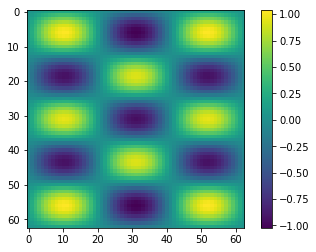

In [17]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

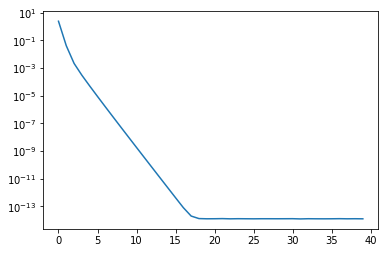

In [18]:
plt.semilogy(GMM_Res)

**Calculate Spectral Radius**

In [19]:
GMM_rho = rho(inputsize,A,P,R,w,s)
print(GMM_rho)

0.700832950209785


## DMM

**Optimize R, P, $\omega$**

In [20]:
Pnew, Rnew, wnew, Rhoold, Rhonew = homotopy_optimizer_GD(inputsize, A, A, P, R, w, s, learning_rate = 0.001 ,accept_radius = GMM_rho,step_length = 0.01)

L = 0.02
rho = 0.6326838385932566
L = 0.03
rho = 0.5741308668766337
L = 0.04
rho = 0.5234341780257707
L = 0.05
rho = 0.47923693277608054
L = 0.060000000000000005
rho = 0.44046530997390126
L = 0.07
rho = 0.4062598334267098
L = 0.08
rho = 0.37592569890560307
L = 0.09
rho = 0.34889612405318504
L = 0.09999999999999999
rho = 0.3247049198599115
L = 0.10999999999999999
rho = 0.3029657096850839
L = 0.11999999999999998
rho = 0.28335600880168527
L = 0.12999999999999998
rho = 0.26560490271655685
L = 0.13999999999999999
rho = 0.24948342069159934
L = 0.15
rho = 0.23479694912221818
L = 0.16
rho = 0.22137920390207122
L = 0.17
rho = 0.20908740510988547
L = 0.18000000000000002
rho = 0.19779838682185727
L = 0.19000000000000003
rho = 0.1874054400044271
L = 0.20000000000000004
rho = 0.17781573437033435
L = 0.21000000000000005
rho = 0.16894820067524954
L = 0.22000000000000006
rho = 0.16073178160346716
L = 0.23000000000000007
rho = 0.1531039795438427
L = 0.24000000000000007
rho = 0.1460096449052005
L = 0.25

**Calculate Result and Residual**

In [22]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A, RightF, Pnew, Rnew, s, wnew, 40)

Residual = 2.4466479049197787
Interation = 0
Residual = 0.030439581428146446
Interation = 1
Residual = 0.0016020323660289727
Interation = 2
Residual = 0.0003501257426434722
Interation = 3
Residual = 8.803884215431136e-05
Interation = 4
Residual = 2.2482991711407496e-05
Interation = 5
Residual = 5.754857580813339e-06
Interation = 6
Residual = 1.4738408901842626e-06
Interation = 7
Residual = 3.7755049581421215e-07
Interation = 8
Residual = 9.673298788152045e-08
Interation = 9
Residual = 2.4787563121232884e-08
Interation = 10
Residual = 6.352475003091535e-09
Interation = 11
Residual = 1.6281505394788007e-09
Interation = 12
Residual = 4.173344773661499e-10
Interation = 13
Residual = 1.0698088911171661e-10
Interation = 14
Residual = 2.7425281783050293e-11
Interation = 15
Residual = 7.0313060172960865e-12
Interation = 16
Residual = 1.8015459321809413e-12
Interation = 17
Residual = 4.613740521534344e-13
Interation = 18
Residual = 1.197156275032317e-13
Interation = 19
Residual = 3.492911982012

**Plot Result**

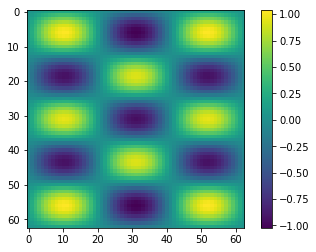

In [23]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

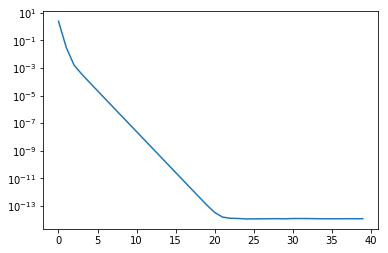

In [24]:
plt.semilogy(DMM_Res)

**Calculate Spectral Radius**

In [25]:
DMM_radius = Rhonew
print(Rhonew)

0.01906153665347315


## Compare

In [26]:
print('GMM_rho = {}'.format(GMM_rho))
print('DMM_rho = {}'.format(Rhonew))

GMM_rho = 0.700832950209785
DMM_rho = 0.01906153665347315


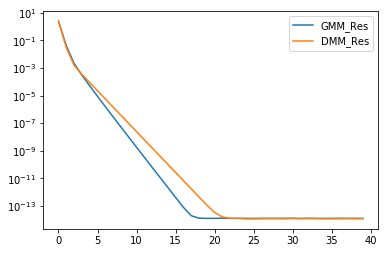

In [27]:
plt.semilogy(GMM_Res, label = 'GMM_Res')
plt.semilogy(DMM_Res, label = 'DMM_Res')
plt.legend(loc='upper right')

## R, P and  $\omega$ after Optimization

In [28]:
print('omega after optimization = {}'.format(wnew))

omega after optimization = 0.8646068300010896


P after optimization 


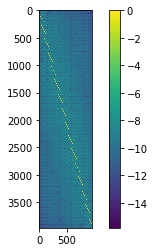

In [29]:
print('P after optimization ')
plt.imshow(np.log10(np.abs(Pnew)))
plt.colorbar()

R after optimization 


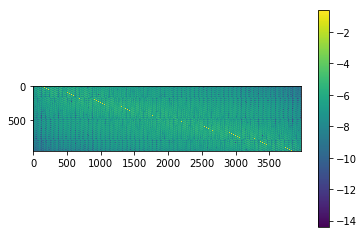

In [30]:
print('R after optimization ')
plt.imshow(np.log10(np.abs(Rnew)))
plt.colorbar()

P under log10(abs())


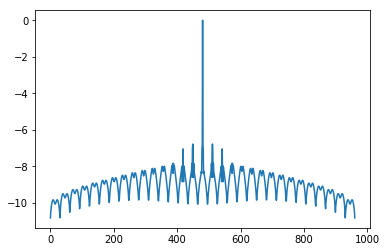

In [31]:
print("P under log10(abs())")
plt.plot(np.log10(np.abs(Pnew))[round(0.5*inputsize)][:])

R under log10(abs())


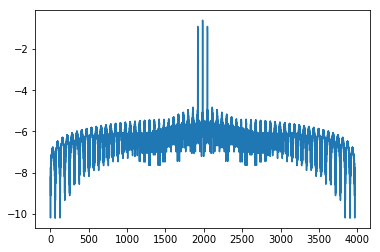

In [32]:
print("R under log10(abs())")
plt.plot(np.log10(np.abs(Rnew))[:][round(0.5*outputsize)])